Loading train/test splits...
X_train shape: (3392, 15)
X_test shape: (848, 15)

Setting up Grid Search for Lasso Logistic Regression with sub-sampling...
Running Grid Search with sub-sampling...
Fitting 5 folds for each of 52 candidates, totalling 260 fits

Best Parameters (sub-sampling):
{'C': 0.05, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-Validated F1-Score: 0.6580

Test Set Results (sub-sampling):
Accuracy: 0.6616

Classification Report (sub-sampling):
              precision    recall  f1-score   support

           0       0.92      0.66      0.77       719
           1       0.26      0.67      0.38       129

    accuracy                           0.66       848
   macro avg       0.59      0.67      0.57       848
weighted avg       0.82      0.66      0.71       848

Number of selected features (non-zero coefficients): 6
Number of unselected features (zero coefficients): 9
Selected features:
['cigsPerDay', 'glucose', 'male', 'education', 'currentSmoker', 'diabetes']


/opt/anaconda3/envs/thesis_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


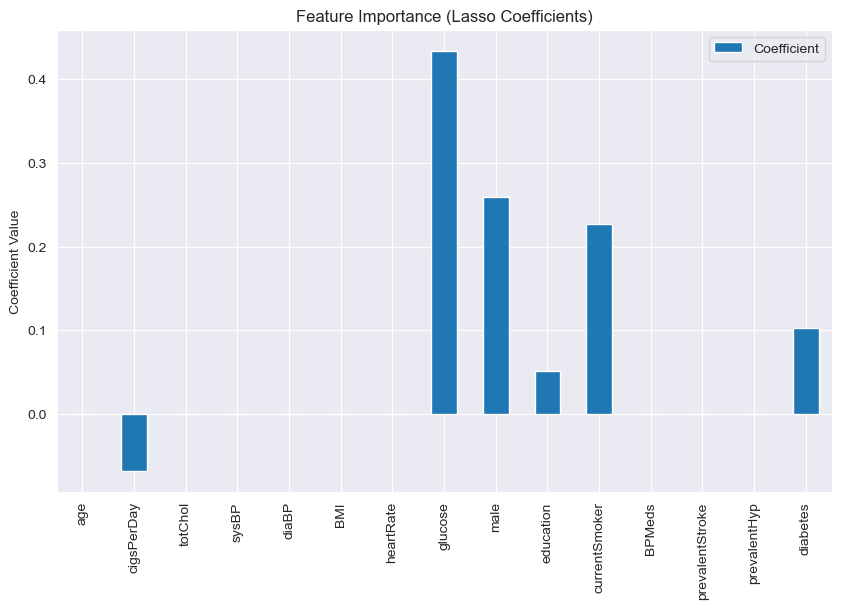

Odds Ratios:
age: 1.00
cigsPerDay: 0.93
totChol: 1.00
sysBP: 1.00
diaBP: 1.00
BMI: 1.00
heartRate: 1.00
glucose: 1.54
male: 1.30
education: 1.05
currentSmoker: 1.26
BPMeds: 1.00
prevalentStroke: 1.00
prevalentHyp: 1.00
diabetes: 1.11


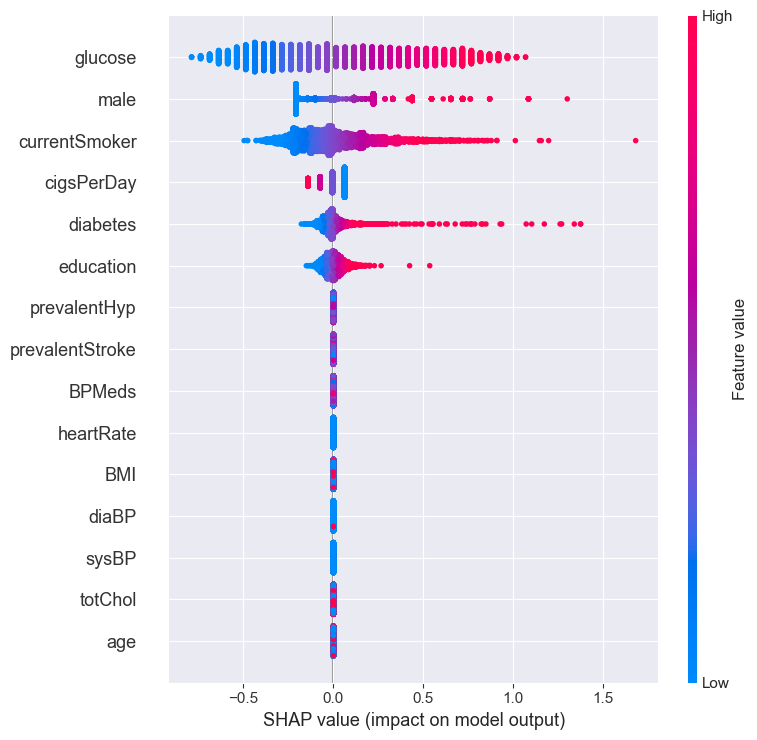

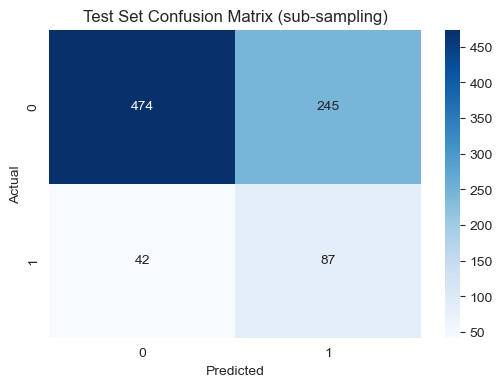


Best model with sub-sampling saved to ../models/lasso_best_model_subsampling.pkl
Grid search results for sub-sampling saved to ../results/lasso_gridsearch_results_subsampling.csv


/opt/anaconda3/envs/thesis_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


NameError: name 'f1_score' is not defined

In [6]:
# --- 03_lasso_regression_gridsearch_subsampling.ipynb ---

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.utils import resample
import shap

# 1. Load preprocessed data
print("Loading train/test splits...")
X_train = np.load("../data/splits/X_train.npy")
y_train = np.load("../data/splits/y_train.npy")
X_test = np.load("../data/splits/X_test.npy")
y_test = np.load("../data/splits/y_test.npy")

# Convert numpy arrays back to pandas DataFrame
# Assuming the feature names are consistent
X_train_columns = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'male', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']
X_train = pd.DataFrame(X_train, columns=X_train_columns)
X_test = pd.DataFrame(X_test, columns=X_train_columns)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}\n")

# 2. Set up GridSearchCV for Lasso Logistic Regression
param_grid = {
    #'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5,
      0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5,
      4.0, 4.5, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 15.0, 20.0,
      25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0,
      70.0, 75.0, 80.0, 85.0, 90.0, 95.0, 100.0, 150.0,
      200.0, 250.0, 300.0, 400.0, 500.0],  # Expanded regularization strength values

    'penalty': ['l1'],             # L1 penalty for sparsity
    'solver': ['liblinear'],       # liblinear supports l1
}

# ==============================
# Part 1: Sub-sampling the Majority Class
# ==============================
print("Setting up Grid Search for Lasso Logistic Regression with sub-sampling...")

# Down-sample the majority class
X_minority = X_train[y_train == 1]
y_minority = y_train[y_train == 1]

X_majority = X_train[y_train == 0]
y_majority = y_train[y_train == 0]

# Down-sample majority class to match minority class
X_majority_downsampled, y_majority_downsampled = resample(X_majority, y_majority,
                                                          replace=False,
                                                          n_samples=len(X_minority),
                                                          random_state=42)

# Combine minority class with downsampled majority class
X_resampled = np.vstack((X_majority_downsampled, X_minority))
y_resampled = np.hstack((y_majority_downsampled, y_minority))

# Run GridSearchCV on the resampled data
print("Running Grid Search with sub-sampling...")
grid_search_subsampling = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid,
    scoring='f1',  # Optimize for F1-Score (important for imbalanced data)
    cv=5,          # 5-fold cross-validation
    verbose=2,
    n_jobs=-1      # Use all cores for parallel processing
)

grid_search_subsampling.fit(X_resampled, y_resampled)

print("\nBest Parameters (sub-sampling):")
print(grid_search_subsampling.best_params_)
print(f"Best Cross-Validated F1-Score: {grid_search_subsampling.best_score_:.4f}\n")

# 3. Evaluate best model with sub-sampling on test set
best_model_subsampling = grid_search_subsampling.best_estimator_
y_test_pred_subsampling = best_model_subsampling.predict(X_test)

print("Test Set Results (sub-sampling):")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_subsampling):.4f}")
print()
print("Classification Report (sub-sampling):")
print(classification_report(y_test, y_test_pred_subsampling))

# ==============================
# Sparsity and Feature Importance
# ==============================
# Get the coefficients of the features in the final model (non-zero features are important)
coefficients = pd.DataFrame(best_model_subsampling.coef_[0], index=X_train.columns, columns=['Coefficient'])

# Get non-zero coefficients (sparse features)
non_zero_coeffs = coefficients[coefficients['Coefficient'] != 0]
print(f"Number of selected features (non-zero coefficients): {len(non_zero_coeffs)}")

# Count the number of unselected features (zero coefficients)
num_zero_coeffs = len(coefficients) - len(non_zero_coeffs)
print(f"Number of unselected features (zero coefficients): {num_zero_coeffs}")

# Optionally, print out the names of the selected and unselected features
print("Selected features:")
print(non_zero_coeffs.index.tolist())

print("Unselected features:")
unselected_features = coefficients[coefficients['Coefficient'] == 0].index.tolist()
print(unselected_features)

# Plot the coefficients (feature importance)
coefficients.plot(kind='bar', figsize=(10,6))
plt.title('Feature Importance (Lasso Coefficients)')
plt.ylabel('Coefficient Value')
plt.show()

# ==============================
# Odds Ratios for interpretability
# ==============================
odds_ratios = np.exp(best_model_subsampling.coef_[0])  # Exponentiate the coefficients to get odds ratios
print("Odds Ratios:")
for feature, odds in zip(X_train.columns, odds_ratios):
    print(f"{feature}: {odds:.2f}")

# ==============================
# SHAP Values for Interpretability
# ==============================
# Initialize SHAP Explainer
explainer = shap.Explainer(best_model_subsampling, X_train)

# Get SHAP values for all predictions
shap_values = explainer(X_train)

# Summary plot to show feature contributions across all predictions
shap.summary_plot(shap_values, X_train)

# 4. Confusion Matrix for sub-sampling
cm_subsampling = confusion_matrix(y_test, y_test_pred_subsampling)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_subsampling, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test Set Confusion Matrix (sub-sampling)")
plt.show()

# 5. Save best model to disk
os.makedirs("../models", exist_ok=True)
model_path_subsampling = "../models/lasso_best_model_subsampling.pkl"
joblib.dump(best_model_subsampling, model_path_subsampling)
print(f"\nBest model with sub-sampling saved to {model_path_subsampling}")

# 6. (Optional) Save GridSearch Results to CSV
results_df_subsampling = pd.DataFrame(grid_search_subsampling.cv_results_)
results_df_subsampling.to_csv("../results/lasso_gridsearch_results_subsampling.csv", index=False)
print("Grid search results for sub-sampling saved to ../results/lasso_gridsearch_results_subsampling.csv")

# ==============================
# 7. Threshold optimization for F1
# ==============================

# Wahrscheinlichkeiten vorhersagen
y_probs = best_model_subsampling.predict_proba(X_test)[:, 1]

# Thresholds testen und F1 berechnen
thresholds = np.linspace(0, 1, 100)
f1_scores = [f1_score(y_test, (y_probs >= t).astype(int)) for t in thresholds]

# Besten Threshold auswählen
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\nOptimaler Threshold: {best_threshold:.2f}")
print(f"F1-Score bei optimalem Threshold: {best_f1:.4f}")

# Plot
plt.plot(thresholds, f1_scores)
plt.xlabel("Threshold")
plt.ylabel("F1-Score")
plt.title("F1-Score vs Threshold")
plt.grid(True)
plt.show()

# Neue Vorhersage mit optimalem Threshold
y_test_pred_opt = (y_probs >= best_threshold).astype(int)

print("Classification Report (optimierter Threshold):")
print(classification_report(y_test, y_test_pred_opt))

# Neue Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_test_pred_opt), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (optimierter Threshold)")
plt.show()

